# Exploring Missing Values in Facility Records Dataset

In [1]:
# Standard library imports
import sys
import os
from pathlib import Path

# Add the path to 'database_functions.py'
path = Path('..', '002_database-functions')
sys.path.append(str(path))

# Third-party library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import requests

# Custom module imports
import database_functions as func
from eda_functions import choropleth

# Configure inline plotting for Jupyter
%matplotlib inline


# Create a Database instance
path = r'008_supplemental\002_clean-data'
db = func.Database(path)
print("Database initialized successfully.")


Database initialized successfully.


## Task 1: Basic statistics and data overview of the 'fascility' table

In [3]:

def load_facility_records(db=None):
    
    if db is None:
        db = func.Database()
        
    # Load the facility_records table
    facility_records_df = db.facility_records()

    # remove '_1' from the column names, '_1' was added to the column names to avoid conflicts with the column names from aggregated fasciltiy table
    facility_records_df.columns = [col.replace('_1', '') for col in facility_records_df.columns]

    # cast mortality_rate_facility and readmission_rate_facility to numeric
    facility_records_df['mortality_rate_facility'] = pd.to_numeric(facility_records_df['mortality_rate_facility'], errors='coerce')   
    facility_records_df['readmission_rate_facility'] = pd.to_numeric(facility_records_df['readmission_rate_facility'], errors='coerce')
    
    # rename patient_hospital_readmission_category column
    facility_records_df.rename(columns={'patient_hospital_readmission_category': 'readmission_category'}, inplace=True)
    
    view_columns = ['year', 'county_name', 'stations', 'prof_np', 'chain_own', 'chain_org', 'mortality_rate_facility', 'readmission_rate_facility', 'readmission_category', 'fac_star', 'xp_star', 'staff_scr']
    db.facility_records.add_view('quality_of_care', view_columns)
    # Sort the dataframe by year and county_name
    fascility_records_df = db.facility_records.quality_of_care.sort_values(['year', 'county_name']).reset_index(drop=True)

    return fascility_records_df

facility_records_df = load_facility_records(db)
print(facility_records_df.describe().T)

                             count         mean       std     min     25%  \
year                       37738.0  2021.027717  1.979136  2018.0  2019.0   
stations                   37741.0    20.639517  9.508625     0.0    16.0   
mortality_rate_facility    35434.0    21.802489  6.728506     0.0    17.6   
readmission_rate_facility  35342.0    26.576122  7.373863     0.0    22.1   
fac_star                   23504.0     3.663802  0.957137     1.0     3.0   
xp_star                    19895.0     3.611058  0.814083     1.0     3.0   
staff_scr                  23504.0    87.284717  3.733921    70.0    85.0   

                              50%     75%     max  
year                       2021.0  2023.0  2024.0  
stations                     21.0    25.0    76.0  
mortality_rate_facility      21.0    24.9    83.5  
readmission_rate_facility    26.6    30.9    70.6  
fac_star                      4.0     4.0     5.0  
xp_star                       4.0     4.0     5.0  
staff_scr          

## Task 2. Visualiz Missing Values Heatmap

Missing value counts:
year                             3
county_name                    800
stations                         0
prof_np                          0
chain_own                        0
chain_org                        6
mortality_rate_facility       2307
readmission_rate_facility     2399
readmission_category          4448
fac_star                     14237
xp_star                      17846
staff_scr                    14237
dtype: int64


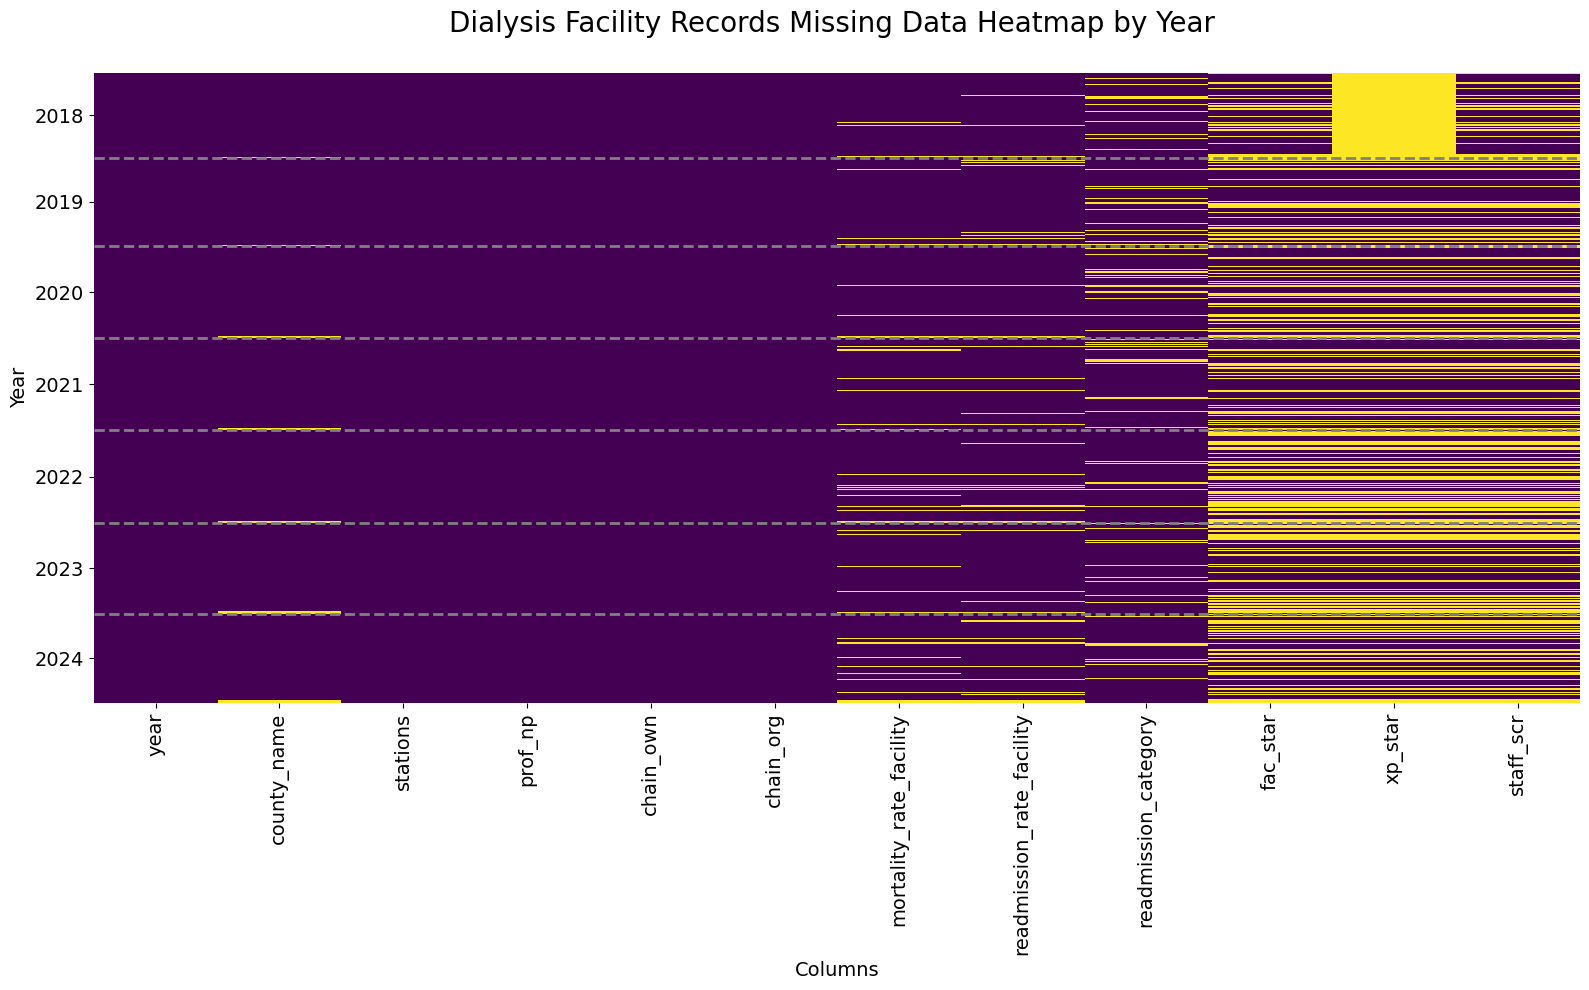

In [4]:
def plot_missing_data_heatmap(df):
    
    # Create the heatmap
    plt.figure(figsize=(16, 10))
    ax = sns.heatmap(facility_records_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)

    # Add horizontal lines to separate years
    years = facility_records_df['year'].dropna().unique()
    year_indices = [facility_records_df[facility_records_df['year'] == year].index[0] for year in years]
    for idx in year_indices[1:]:  # Start from the second year
        plt.axhline(y=idx, color='gray', linestyle='--', linewidth=2)

    # Set y-axis ticks and labels
    ax.set_yticks([idx + (year_indices[i+1] - idx)/2 if i+1 < len(year_indices) else idx + (len(facility_records_df) - idx)/2 
                for i, idx in enumerate(year_indices)])
    ax.set_yticklabels([int(year) for year in years], rotation=0, fontsize= 14)  # Convert years to integers
    ax.set_xticklabels(ax.get_xticklabels(), fontsize= 14)
    

    plt.title('Dialysis Facility Records Missing Data Heatmap by Year \n', fontsize=20)
    plt.xlabel('Columns', fontsize=14)
    plt.ylabel('Year', fontsize=14)
    plt.tight_layout()
    return ax


# Count missing values in each column
missing_counts = facility_records_df.isnull().sum()
print("Missing value counts:")
print(missing_counts)

g = plot_missing_data_heatmap(facility_records_df)
plt.show()


In [5]:
# Get the output path
current_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.abspath(os.path.join(current_dir, '..', '..', '..'))
visualizations_dir = os.path.join(project_root, '007_visualizations')
output_path = os.path.join(visualizations_dir, '001_missing_data_heatmap.png')

# # Save the figure
# g.figure.savefig(output_path)